In [169]:
import pandas as pd
import re
import string

In [170]:
products = pd.DataFrame.from_csv('amazon_baby.csv')

In [171]:
products = products.fillna({'review': ''})

In [172]:
regex = re.compile('[%s]' % re.escape(string.punctuation))
def remove_punctuation(text):
    return regex.sub('', text)
products['review_clean'] = products['review'].apply(remove_punctuation)

In [173]:
# Ignore all the reviews with rating = 3
products = products[products['rating'] != 3].reset_index()

In [174]:
products['sentiment'] = products['rating'].apply(lambda x: 1 if x >= 4 else -1)

In [175]:
train_idx = pd.read_json('module-9-assignment-train-idx.json')[0]
test_idx = pd.read_json('module-9-assignment-test-idx.json')[0]

In [176]:
train_data = products.ix[train_idx]
test_data = products.ix[test_idx]

In [177]:
from sklearn.feature_extraction.text import CountVectorizer

In [178]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
# Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])

In [179]:
from sklearn.linear_model import LogisticRegression

In [180]:
model = LogisticRegression()

In [181]:
model.fit(train_matrix, train_data['sentiment'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [182]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true=test_data['sentiment'], y_pred=model.predict(test_matrix))
print("Test Accuracy: %s" % accuracy)

Test Accuracy: 0.932295416367


In [183]:
model.score(test_matrix, test_data['sentiment'])

0.93229541636669067

In [184]:
# Majority class classifier
baseline = sum(test_data['sentiment'] == 1) / float(len(test_data))
print("Baseline accuracy {}".format(baseline))

Baseline accuracy 0.8427825773938085


In [185]:
# Quiz question: Using accuracy as the evaluation metric, was our logistic regression 
# model better than the baseline (majority class classifier)?

# Yes

In [186]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true=test_data['sentiment'],
                        y_pred=model.predict(test_matrix),
                        labels=model.classes_)    # use the same order of class as the LR model.
print(' target_label | predicted_label | count ')
print('--------------+-----------------+-------')
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3788
     -1       |        1        |  1453
      1       |       -1        |   804
      1       |        1        | 27291


In [187]:
# Quiz Question: How many predicted values in the test set are false positives?

# 1453

In [188]:
# Quiz Question: Given the stipulation, what is the cost associated with the logistic 
# regression classifier's performance on the test set?

# 1453 * 100 + 804 * 1

In [189]:
from sklearn.metrics import precision_score
precision = precision_score(y_true=test_data['sentiment'], 
                            y_pred=model.predict(test_matrix))
print("Precision on test data: %s" % precision)

Precision on test data: 0.949450320067


In [190]:
# Quiz Question: Out of all reviews in the test set that are predicted to be positive, 
# what fraction of them are false positives? (Round to the second decimal place e.g. 0.25)

# 1 - 0.949450320067

In [191]:
from sklearn.metrics import recall_score
recall = recall_score(y_true=test_data['sentiment'],
                      y_pred=model.predict(test_matrix))
print("Recall on test data: %s" % recall)

Recall on test data: 0.971382808329


In [192]:
# Quiz Question: What fraction of the positive reviews in the test_set were correctly 
# predicted as positive by the classifier?

# 0.97

In [193]:
# Quiz Question: What is the recall value for a classifier that predicts +1 for all data 
# points in the test_data?

# 1

In [194]:
import numpy as np
def apply_threshold(probabilities, threshold):
    predictions = np.ones(len(probabilities))
    np.place(predictions, probabilities < threshold, -1)
    return predictions

In [195]:
# Test apply_threshold
probabilities = np.array([0.2, 0.6, 0.4, 0.65])
threshold = 0.5
assert np.array_equal(np.array([-1, 1, -1, 1]), apply_threshold(probabilities, threshold))

In [196]:
probabilities = model.predict_proba(test_matrix)[:, 1]

In [197]:
predictions_50 = apply_threshold(probabilities, 0.5)
predictions_90 = apply_threshold(probabilities, 0.9)

In [198]:
sum(predictions_50 == 1)

28744

In [199]:
sum(predictions_90 == 1)

25068

In [200]:
# Revisit precision and recall
precision = precision_score(y_true=test_data['sentiment'], 
                            y_pred=predictions_90)
print("Precision on test data: %s" % precision)

Precision on test data: 0.981490346258


In [201]:
recall = recall_score(y_true=test_data['sentiment'],
                      y_pred=predictions_90)
print("Recall on test data: %s" % recall)

Recall on test data: 0.875743014771


In [202]:
# Quiz Question (variant 1): Does the precision increase with a higher threshold?

# Yes

# Quiz Question (variant 2): Does the recall increase with a higher threshold?

# No

In [203]:
threshold_values = np.linspace(0.5, 1, num=100)
print(threshold_values)

[ 0.5         0.50505051  0.51010101  0.51515152  0.52020202  0.52525253
  0.53030303  0.53535354  0.54040404  0.54545455  0.55050505  0.55555556
  0.56060606  0.56565657  0.57070707  0.57575758  0.58080808  0.58585859
  0.59090909  0.5959596   0.6010101   0.60606061  0.61111111  0.61616162
  0.62121212  0.62626263  0.63131313  0.63636364  0.64141414  0.64646465
  0.65151515  0.65656566  0.66161616  0.66666667  0.67171717  0.67676768
  0.68181818  0.68686869  0.69191919  0.6969697   0.7020202   0.70707071
  0.71212121  0.71717172  0.72222222  0.72727273  0.73232323  0.73737374
  0.74242424  0.74747475  0.75252525  0.75757576  0.76262626  0.76767677
  0.77272727  0.77777778  0.78282828  0.78787879  0.79292929  0.7979798
  0.8030303   0.80808081  0.81313131  0.81818182  0.82323232  0.82828283
  0.83333333  0.83838384  0.84343434  0.84848485  0.85353535  0.85858586
  0.86363636  0.86868687  0.87373737  0.87878788  0.88383838  0.88888889
  0.89393939  0.8989899   0.9040404   0.90909091  0.

In [204]:
precision_all = []
recall_all = []

In [205]:
for t in threshold_values:
    predictions_t = apply_threshold(probabilities, t)
    precision_all.append(precision_score(y_true=test_data['sentiment'], y_pred=predictions_t))
    recall_all.append(recall_score(y_true=test_data['sentiment'], y_pred=predictions_t))

In [206]:
import matplotlib.pyplot as plt
%matplotlib inline

In [207]:
def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})

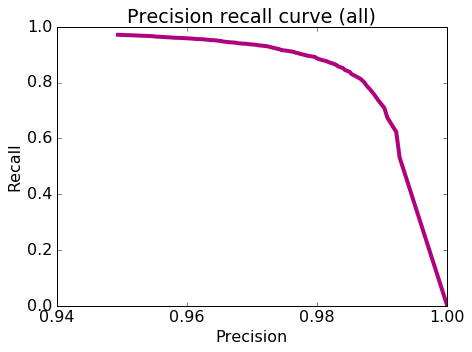

In [208]:
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

In [209]:
# Quiz Question: Among all the threshold values tried, what is the smallest threshold 
# value that achieves a precision of 96.5% or better? Round your answer to 3 decimal places.

threshold_values[np.argmax(np.array(precision_all) > 0.965)]

0.70707070707070707

In [210]:
# Quiz Question: Using threshold = 0.98, how many false negatives do we get on the test_data? 
# This is the number of false negatives (i.e the number of reviews to look at when not needed) 
# that we have to deal with using this classifier.

In [211]:
predictions = apply_threshold(probabilities, 0.98)
sum(predictions[predictions != test_data['sentiment']] == -1)

d:\Users\zeyang\Miniconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  from ipykernel import kernelapp as app


24932

In [212]:
test_data['name'] = test_data['name'].astype(str)

In [213]:
baby_reviews = test_data[test_data['name'].apply(lambda x: 'baby' in x.lower())]

In [214]:
baby_matrix = vectorizer.transform(baby_reviews['review_clean'])
probabilities = model.predict_proba(baby_matrix)[:,1]

In [215]:
threshold_values = np.linspace(0.5, 1, num=100)

In [216]:
precision_all = []
recall_all = []

In [217]:
for t in threshold_values:
    predictions_t = apply_threshold(probabilities, t)
    precision_all.append(precision_score(y_true=baby_reviews['sentiment'], y_pred=predictions_t))
    recall_all.append(recall_score(y_true=baby_reviews['sentiment'], y_pred=predictions_t))

In [218]:
# Quiz Question: Among all the threshold values tried, what is the smallest 
# threshold value that achieves a precision of 96.5% or better for the reviews of data 
# in baby_reviews?  Round your answer to 3 decimal places.

threshold_values[np.argmax(np.array(precision_all) > 0.965)]

0.73737373737373746

In [219]:
# Quiz Question: Is this threshold value smaller or larger 
# than the threshold used for the entire dataset to achieve the same specified precision of 
# 96.5%?

# Higher

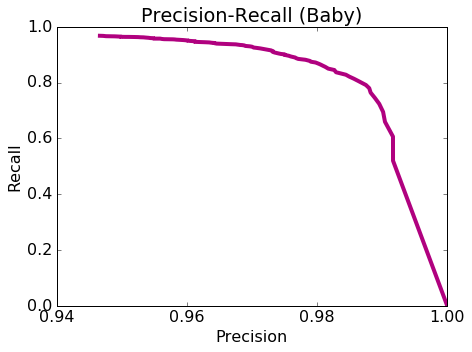

In [220]:
plot_pr_curve(precision_all, recall_all, "Precision-Recall (Baby)")